In [271]:
!git clone -b dev-rose https://github.com/Finweto/Projet-deep-learning-2022.git
!ls
!ls Projet-deep-learning-2022/dataset_processed
print("***")
!ls -l Projet-deep-learning-2022/dataset_processed/Train

fatal: destination path 'Projet-deep-learning-2022' already exists and is not an empty directory.
ancien	Projet-deep-learning-2022  sample_data
Test  Train
***
total 44
drwxr-xr-x 2 root root 4096 Dec  3 17:58 amborella
drwxr-xr-x 2 root root 4096 Dec  3 17:58 castanea
drwxr-xr-x 2 root root 4096 Dec  3 17:58 convolvulaceae
drwxr-xr-x 2 root root 4096 Dec  3 17:58 desmodium
drwxr-xr-x 2 root root 4096 Dec  3 17:58 eugenia
drwxr-xr-x 2 root root 4096 Dec  3 17:58 laurus
drwxr-xr-x 2 root root 4096 Dec  3 17:58 litsea
drwxr-xr-x 2 root root 4096 Dec  3 17:58 magnolia
drwxr-xr-x 2 root root 4096 Dec  3 17:58 monimiaceae
drwxr-xr-x 2 root root 4096 Dec  3 17:58 rubus
drwxr-xr-x 2 root root 4096 Dec  3 17:58 ulmus


In [272]:
# Imports (certains peut etre pas utiles)
import itertools
import os
import pathlib
import random
import typing

import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import sklearn.utils
import sklearn.metrics
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

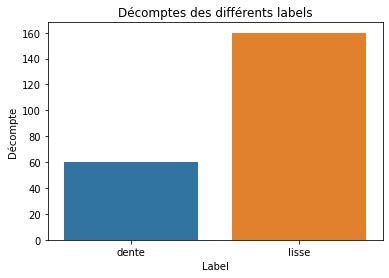

In [273]:
################################################ MODELE 1 : BORDS ########################################

## CHOIX DE LA FEATURE :
label_names = ["dente", "lisse"] # Le 2ème élement du tableau sera celui converti en "1", le premier sera converti en 0
feature = "bord"



# Récupération des données préparées
data_train_labeled=pd.read_csv('Projet-deep-learning-2022/data_train_labeled.csv')


def get_images(filename):

  df=pd.read_csv(filename)
  images = []
  labels = []

  for i in range(len(df[feature])):
    path=df["img_path"][i]

    image=cv2.imread("Projet-deep-learning-2022/"+path)
    image=cv2.resize(image,(150,150))
    images.append(image)

    label=df[feature][i]
    ## ON DECIDE ICI DE LA CARACTERISTIQUE SUR LAQUELLE S'ENTRAINER
    # On convertit la réponse binaire en valeur numérique True/False où True = oui
    # OPTIMISABLE ?
    if df[feature][i]==label_names[1]:
      label = 1
    else:
      label = 0
    
    labels.append(label)

    # Mélange des tableaux
    images, labels = sklearn.utils.shuffle(images, labels)

  return images,labels



label_to_index = {l: i for i, l in enumerate(label_names)} # Pas utilisé pour l'instant
images, labels= get_images("Projet-deep-learning-2022/data_train_labeled.csv")

seaborn.countplot(x=data_train_labeled[feature])
plt.title("Décomptes des différents labels")
plt.ylabel("Décompte")
plt.xlabel("Label")
plt.show()

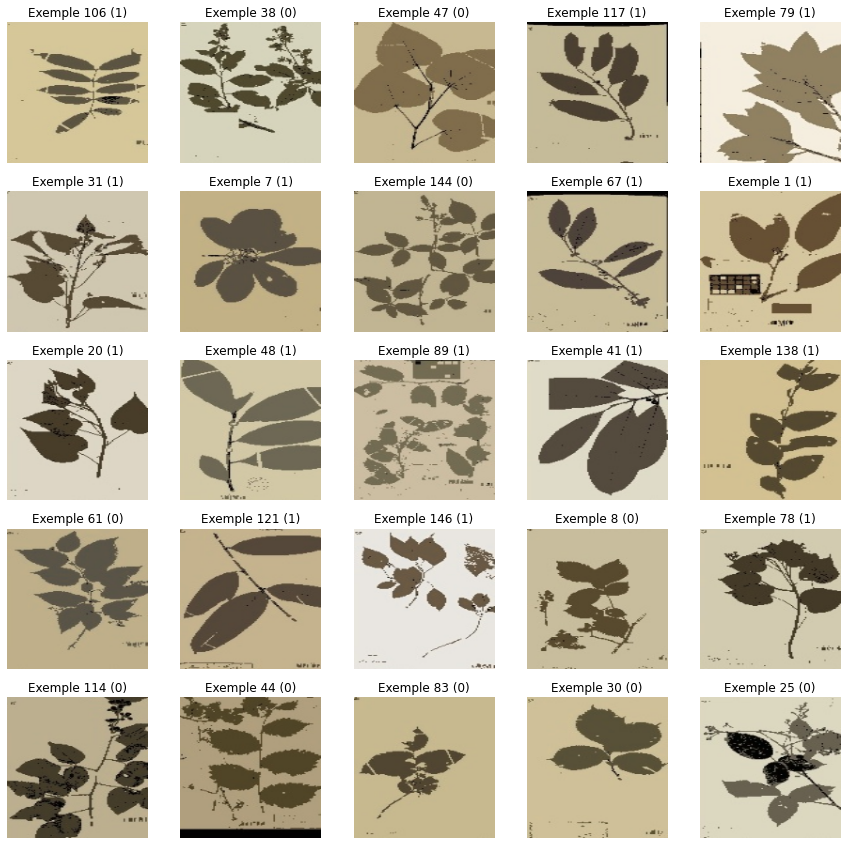

In [274]:
## Affichage des données

# Création de la grille de sous-plots. On donne l'argument figsize pour agrandir
# la taille de la figure qui est petite par défaut
f, ax = plt.subplots(5, 5, figsize=(15, 15))

# On choisit 25 indices au hasard, sans replacement (on ne veut pas afficher la
# même image deux fois)
random_indexes = np.random.choice(images[0].shape[0],
                                     size=(5, 5),
                                     replace=False)

for i in range(5):
  for j in range(5):
    img_index = random_indexes[i, j]
    image = images[img_index]
    label = labels[img_index]

    # Affichage avec matplotlib et sa fonction imshow, très pratique en vision par
    # ordinateur
    ax[i, j].imshow(image)
    ax[i, j].set_title(f"Exemple {img_index} ({label})")
    ax[i, j].axis('off')


In [275]:
################################################ CONSTRUCTION DU MODELE ########################################

## Version COMPLEXE (pour l'instant fait planter l'apprentissage)

conv2d_params = dict(kernel_size=(3,3),
                     activation="relu",
                     kernel_initializer="orthogonal",
                     padding="same")

dense_params = dict(activation="relu", kernel_initializer="orthogonal")

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(200, input_shape=(150, 150, 3), **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(200, **dense_params))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(100, **dense_params))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(50, **dense_params))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(11,
                             activation="softmax",
                             kernel_initializer="orthogonal"))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Affichage d'un résumé du modèle
model.summary()


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_101 (Conv2D)         (None, 150, 150, 200)     5600      
                                                                 
 max_pooling2d_89 (MaxPoolin  (None, 75, 75, 200)      0         
 g2D)                                                            
                                                                 
 conv2d_102 (Conv2D)         (None, 75, 75, 200)       360200    
                                                                 
 max_pooling2d_90 (MaxPoolin  (None, 38, 38, 200)      0         
 g2D)                                                            
                                                                 
 conv2d_103 (Conv2D)         (None, 38, 38, 200)       360200    
                                                                 
 max_pooling2d_91 (MaxPoolin  (None, 19, 19, 200)    

In [286]:
## Version SIMPLE

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(10,
                              kernel_size=(3, 3),
                              activation="relu",
                              input_shape=(150, 150, 3)))
model.add(keras.layers.MaxPool2D(3,3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(11, activation="softmax"))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_109 (Conv2D)         (None, 148, 148, 10)      280       
                                                                 
 max_pooling2d_96 (MaxPoolin  (None, 49, 49, 10)       0         
 g2D)                                                            
                                                                 
 flatten_31 (Flatten)        (None, 24010)             0         
                                                                 
 dense_70 (Dense)            (None, 11)                264121    
                                                                 
Total params: 264,401
Trainable params: 264,401
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
2/2 [==============================] - 2s 458ms/step - loss: 16.9117 - accuracy: 0.6169 - val_loss: 10.0525 - val_accuracy: 0.6970
Epoch 2/40
2/2 [==============================] - 1s 443ms/step - loss: 15.8756 - accuracy: 0.6169 - val_loss: 9.9833 - val_accuracy: 0.6970
Epoch 3/40
2/2 [==============================] - 1s 450ms/step - loss: 15.0801 - accuracy: 0.5974 - val_loss: 10.3155 - val_accuracy: 0.6667
Epoch 4/40
2/2 [==============================] - 1s 423ms/step - loss: 14.9387 - accuracy: 0.5390 - val_loss: 11.0707 - val_accuracy: 0.6667
Epoch 5/40
2/2 [==============================] - 1s 452ms/step - loss: 15.4624 - accuracy: 0.5130 - val_loss: 11.3863 - val_accuracy: 0.6667
Epoch 6/40
2/2 [==============================] - 1s 453ms/step - loss: 15.4917 - accuracy: 0.5130 - val_loss: 10.8681 - val_accuracy: 0.6818
Epoch 7/40
2/2 [==============================] - 1s 423ms/step - loss: 14.9803 - accuracy: 0.5130 - val_loss: 10.2445 - val_accuracy: 0.6667
Epoch 8

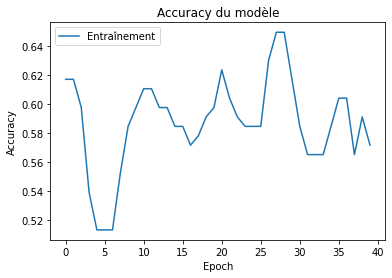

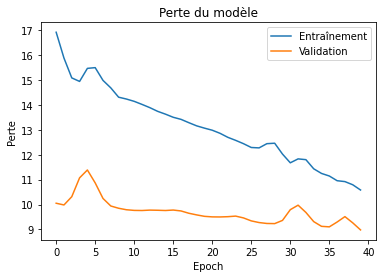

In [289]:
################################################ APPRENTISSAGE ########################################

# Apprentissage du modèle
images=np.array(images)
labels=np.array(labels)
#labels_int=[label_names.index(x) for x in labels]
#labels_int=np.array(labels_int)


training = model.fit(images, labels, epochs=40, batch_size=128, validation_split=0.30)


# Visualisation des métriques d'entrainement
def plot_metrics(history) -> None:
  plt.plot(training.history["accuracy"])
  #plt.plot(training.history["val_accuracy"])
  plt.title("Accuracy du modèle")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Entraînement", "Validation"], loc="upper left")
  plt.show()

  plt.plot(training.history["loss"])
  plt.plot(training.history["val_loss"])
  plt.title("Perte du modèle")
  plt.ylabel("Perte")
  plt.xlabel("Epoch")
  plt.legend(["Entraînement", "Validation"], loc="upper right")
  plt.show()


plot_metrics(training.history)

In [284]:
## Evaluation du modèle
test_images, test_labels = get_images("Projet-deep-learning-2022/data_test_labeled.csv")

In [290]:
model.evaluate(np.array(test_images), np.array(test_labels), verbose=1)

4/4 [==============================] - 0s 84ms/step - loss: 12.1097 - accuracy: 0.6182


[12.109716415405273, 0.6181818246841431]

4/4 [==============================] - 0s 82ms/step


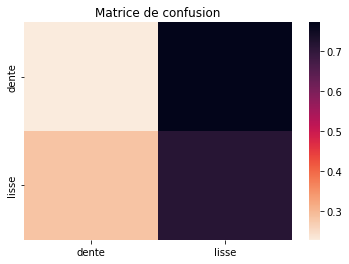

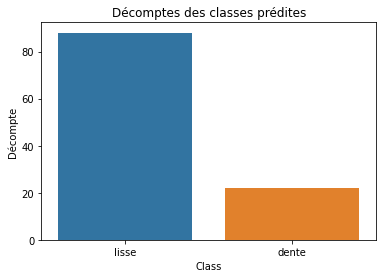

In [291]:
def analyze_preds(preds, labels):
  confusion_matrix = sklearn.metrics.confusion_matrix(preds,
                                                      labels,
                                                      normalize="true")
  seaborn.heatmap(confusion_matrix,
                  cmap="rocket_r",
                  xticklabels=label_names,
                  yticklabels=label_names)
  plt.title("Matrice de confusion")
  plt.show()

  seaborn.countplot(x=list(map(lambda x: label_names[x], preds)))
  plt.title("Décomptes des classes prédites")
  plt.ylabel("Décompte")
  plt.xlabel("Class")
  plt.show()


test_pred = np.argmax(model.predict(np.array(test_images)), axis=-1)
analyze_preds(test_pred, test_labels)

Prédiction : 1, classe réelle : 0


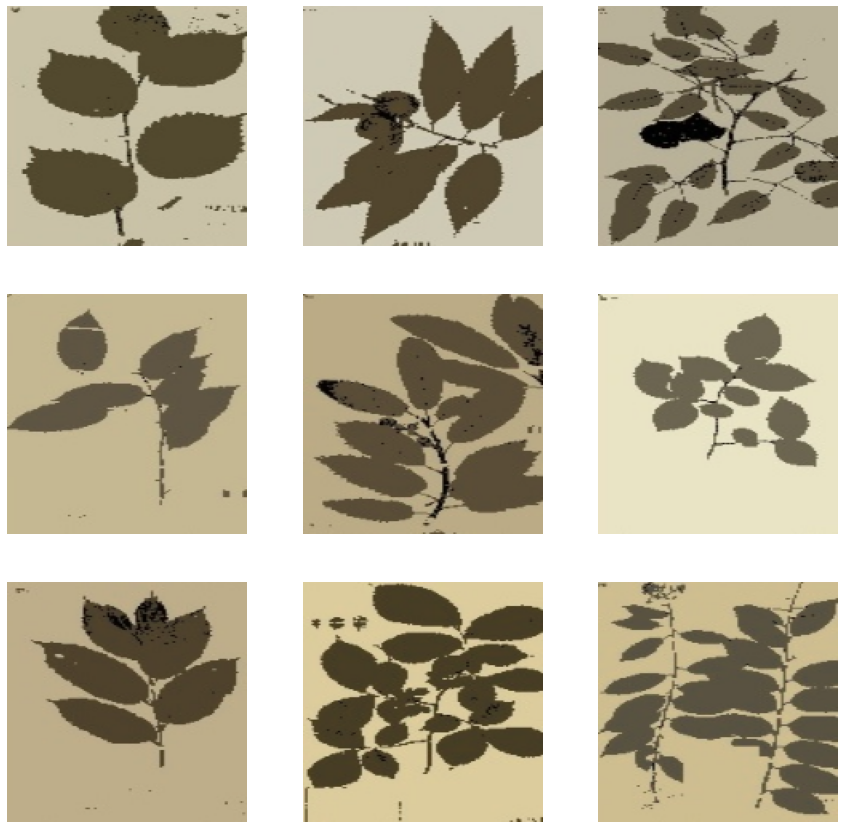

Valeurs prédites par notre modèle :
[0 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0 1
 1 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 0 1 1]

Valeurs réelles :
[1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]


In [281]:
def plot_mistakes(predicted_class: str, true_class: str) -> None:
  print(f"Prédiction : {predicted_class}, classe réelle : {true_class}")
  mistakes=[]

  for index, image in enumerate(test_images):
    if (test_pred[index] == predicted_class) and (test_labels[index] == true_class):
      mistakes.append(image)
  

  random_indexes = np.random.choice(len(mistakes),
                                       size=min(len(mistakes), 9),
                                       replace=False)
  grid_indexes = itertools.product(range(3), repeat=2)

  _, ax = plt.subplots(3, 3, figsize=(15, 15))
  for img_index, (i, j) in zip(random_indexes, grid_indexes):
    ax[i, j].imshow(mistakes[img_index])
    ax[i, j].axis("off")
  plt.show()
  

# On plot quelques unes des images prédites lisses (=1) alors qu'elles sont dentées (=0)
plot_mistakes(1, 0)
print("Valeurs prédites par notre modèle :")
print(test_pred)
print("\nValeurs réelles :")
print(test_labels)